In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC


Welcome to JupyROOT 6.28/00


In [2]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

nsigma_extend=3
thresh=1e1

In [12]:
primary_type = np.dtype([('x', float), ('y', float), ('z', float), ('Edep', float)])
primary_nip_type = np.dtype([('x', float), ('y', float), ('z', float), ('Edep', float), ('NIP', int)])
drifted_type = np.dtype([('pidx', int), ('x', float), ('y', float), ('dt', float)])
readout_type = np.dtype([('x',float), ('y', float), ('dt', float), ('Nel', float)])

In [54]:

def getData(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2
    
    for i, evt in enumerate(f.data):
        if i == saveevt:
            num_carriers = len(evt.x)
            PrimaryEvt = np.empty(num_carriers, dtype=primary_type)
            PrimaryEvt['x'] = np.asarray(evt.x) / 10 + center_z / 10
            PrimaryEvt['y'] = np.asarray(evt.y) / 10 + center_z / 10
            PrimaryEvt['z'] = np.asarray(evt.z) / 10 + center_z / 10
            PrimaryEvt['Edep'] = np.asarray(evt.edep) * 1000
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    num_carriers = len(PrimaryEvt['x'])
    
    PrimaryEvtNIP = np.empty(num_carriers, dtype=primary_nip_type)
    PrimaryEvtNIP[['x', 'y', 'z', 'Edep']] = PrimaryEvt[['x', 'y', 'z', 'Edep']]
    
    nip_list = np.random.poisson(PrimaryEvt['Edep'] / det.wval)
    
    PrimaryEvtNIP['NIP'] = nip_list
    return PrimaryEvtNIP


def driftCarriers(PrimaryEvtNIP, det):
    NIP = PrimaryEvtNIP['NIP'].astype(int)
    z_list = PrimaryEvtNIP['z'].repeat(NIP)
    num_carriers = PrimaryEvtNIP['NIP'].sum()
    
    DriftedEvt = np.empty(num_carriers, dtype=drifted_type)
    DriftedEvt['pidx'] = np.arange(len(NIP)).repeat(NIP)
    
    DriftedEvt['x'] = PrimaryEvtNIP['x'].repeat(NIP) + np.random.normal(loc=0,  scale=driftsigma_trans(z_list, det ))
    
    DriftedEvt['y'] = PrimaryEvtNIP['y'].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det ))
    
    DriftedEvt['dt'] = (PrimaryEvtNIP['z'].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )))/det.vdrift
    
    return DriftedEvt


def gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1):
    minvals = np.array([DriftedEvt['x'].min(),DriftedEvt['y'].min(), DriftedEvt['dt'].min() ])
    maxvals = np.array([DriftedEvt['x'].max(),DriftedEvt['y'].max(), DriftedEvt['dt'].max() ])
    nsigma_extend = 3
    PSFmean_extend = nsigma_extend * det.PSFstd + det.PSFmean
    x_range = (minvals[0] - PSFmean_extend, maxvals[0] + PSFmean_extend)
    y_range = (minvals[1] - PSFmean_extend, maxvals[1] + PSFmean_extend)
    dt_range = (minvals[2] - nsigma_extend * det.gain_sigma_t, maxvals[2] + nsigma_extend * det.gain_sigma_t)
    # Calculate ReadoutGrid
    ReadoutGrid = np.mgrid[
                np.floor(x_range[0] / det.pitch_x) * det.pitch_x:
                np.ceil(x_range[1] / det.pitch_x) * det.pitch_x:
                det.pitch_x,
                np.floor(y_range[0] / det.pitch_y) * det.pitch_y:
                np.ceil(y_range[1] / det.pitch_y) * det.pitch_y:
                det.pitch_y,
                np.floor(dt_range[0] / det.samplerate) * det.samplerate:
                np.ceil(dt_range[1] / det.samplerate) * det.samplerate:
                det.samplerate
                ]

    pos = np.stack(ReadoutGrid, axis=3)
    ReadoutEvt = None
    for i in range(len(DriftedEvt[1])):
        thisGain = np.random.exponential(scale=det.gain_mean)
        rv = multivariate_normal([DriftedEvt['x'][i], DriftedEvt['y'][i], DriftedEvt['dt'][i]], np.diag([det.PSFstd, det.PSFstd, det.gain_sigma_t]))
        if ReadoutEvt is None:
            #The factor pitch_x*pitch_y*sample_rate converts from probability density 
            #to 'normalised' probability
            ReadoutEvt = rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
    themask = ReadoutEvt >= thresh
    readout_length = len(ReadoutEvt[themask])
    ReadoutEvtRet = np.empty(readout_length, dtype=readout_type)
    ReadoutEvtRet['x'] = ReadoutGrid[0][themask].flatten()
    ReadoutEvtRet['y'] = ReadoutGrid[1][themask].flatten()
    ReadoutEvtRet['dt'] = ReadoutGrid[2][themask].flatten()
    ReadoutEvtRet['Nel'] = ReadoutEvt[themask]
    return ReadoutEvtRet

def plotReadout(ReadoutEvt):
    x = ReadoutEvt['x']
    y = ReadoutEvt['y']
    dt = ReadoutEvt['dt']
    Nel = ReadoutEvt['Nel']
    
    # ========================== x y ========================== 
    ### Create unique combinations of x and y values
    unique_xy, unique_indices = np.unique(np.column_stack((x, y)), axis=0, return_index=True)
    unique_Nel = np.zeros(len(unique_xy))  # Initialize an array for summed Nel values

    # Calculate summed Nel values for each unique (x, y) pair
    for i, idx in enumerate(unique_indices):
        mask = (x == x[idx]) & (y == y[idx])
        unique_Nel[i] = np.sum(Nel[mask])

    # Create a new structured array with unique (x, y) pairs and summed Nel values
    dtype = np.dtype([('x', x.dtype), ('y', y.dtype), ('Nel', unique_Nel.dtype)])
    projectxy = np.empty(len(unique_xy), dtype=dtype)
    projectxy['x'] = unique_xy[:, 0]
    projectxy['y'] = unique_xy[:, 1]
    projectxy['Nel'] = unique_Nel
    plt.figure(0)
    plt.scatter(projectxy['x'], projectxy['y'], c = projectxy['Nel'], s = ((projectxy['Nel']/np.max(projectxy['Nel']))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    
    # ========================== x dt ========================== 
    ### Create unique combinations of x and dt values
    unique_xdt, unique_indices = np.unique(np.column_stack((x, dt)), axis=0, return_index=True)
    unique_Nel = np.zeros(len(unique_xdt))  # Initialize an array for summed Nel values

    # Calculate summed Nel values for each unique (x, y) pair
    for i, idx in enumerate(unique_indices):
        mask = (x == x[idx]) & (dt == dt[idx])
        unique_Nel[i] = np.sum(Nel[mask])

    # Create a new structured array with unique (x, y) pairs and summed Nel values
    dtype = np.dtype([('x', x.dtype), ('dt', dt.dtype), ('Nel', unique_Nel.dtype)])
    projectxdt = np.empty(len(unique_xdt), dtype=dtype)
    projectxdt['x'] = unique_xdt[:, 0]
    projectxdt['dt'] = unique_xdt[:, 1]
    projectxdt['Nel'] = unique_Nel
    plt.figure(1)
    plt.scatter(projectxdt['x'], projectxdt['dt'], c = projectxdt['Nel'], s = ((projectxdt['Nel']/np.max(projectxdt['Nel']))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-dt Chart ")
    
    
    # ========================== y dt ========================== 
    ### Create unique combinations of y and dt values
    unique_ydt, unique_indices = np.unique(np.column_stack((y, dt)), axis=0, return_index=True)
    unique_Nel = np.zeros(len(unique_ydt))  # Initialize an array for summed Nel values

    # Calculate summed Nel values for each unique (y, dt) pair
    for i, idx in enumerate(unique_indices):
        mask = (y == y[idx]) & (dt == dt[idx])
        unique_Nel[i] = np.sum(Nel[mask])

    # Create a new structured array with unique (y, dt) pairs and summed Nel values
    dtype = np.dtype([('y', y.dtype), ('dt', dt.dtype), ('Nel', unique_Nel.dtype)])
    projectydt = np.empty(len(unique_ydt), dtype=dtype)
    projectydt['y'] = unique_ydt[:, 0]
    projectydt['dt'] = unique_ydt[:, 1]
    projectydt['Nel'] = unique_Nel
    plt.figure(2)
    plt.scatter(projectydt['y'], projectydt['dt'], c = projectydt['Nel'], s = ((projectydt['Nel']/np.max(projectydt['Nel']))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" Y-dt Chart ")
    
    # ========================== 3d chart ========================== 
    fig = plt.figure(3)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(x, y, dt, c=Nel, cmap='viridis', marker='o')
    plt.title(" X-Y-Z Chart")
    plt.colorbar(scatter)
    plt.show()

In [6]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

# Open ROOT FIle
f = TFile.Open("../../data/simOut_28796KShell.root")

##### Primary Event

In [63]:
%%timeit
saveevt = 1
PrimaryEvt = getData(f, saveevt)

5.23 s ± 109 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
print(PrimaryEvt['x'])


[23.96216995 23.96236844 23.96232853 23.96212538 23.96135451 23.95760213
 23.95678299 23.95728105 23.95709306 23.95771294]


##### Carrier Event

In [64]:
%%timeit
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)

14.6 µs ± 449 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [8]:
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)
print(PrimaryEvtNIP)

[(23.96216995, 26.85175507, 26.81491108, 0.04367   ,  2)
 (23.96236844, 26.85199061, 26.81491721, 0.08379162,  1)
 (23.96232853, 26.85212054, 26.81493353, 0.13658838,  0)
 (23.96212538, 26.85179556, 26.81487233, 0.04938   ,  5)
 (23.96135451, 26.84998614, 26.81505773, 0.02197296,  1)
 (23.95760213, 26.84808033, 26.81632938, 0.66581724, 25)
 (23.95678299, 26.84591105, 26.81451088, 0.37601499, 14)
 (23.95728105, 26.84457497, 26.81278977, 0.43389704, 16)
 (23.95709306, 26.84605251, 26.81273998, 0.01602529,  3)
 (23.95771294, 26.84490717, 26.81340867, 1.05244247, 37)]


In [66]:
%%timeit
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)

55.3 µs ± 1.58 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)
print(DriftedEvt)

[(0, 23.80948672, 26.83927606, 0.15707989)
 (0, 23.94787591, 26.83779133, 0.15612668)
 (1, 24.10156719, 27.04902417, 0.15823284)
 (3, 23.9679107 , 26.86933114, 0.15764715)
 (3, 24.06826535, 26.95354234, 0.15835169)
 (3, 24.02186305, 26.67439389, 0.15685796)
 (3, 23.95752025, 26.87216177, 0.15846769)
 (3, 23.89568683, 26.76228729, 0.15762844)
 (4, 23.92142158, 26.84857375, 0.15761559)
 (5, 23.91683677, 27.02534975, 0.15702321)
 (5, 24.08027135, 26.8967917 , 0.15669483)
 (5, 23.96713307, 26.70891952, 0.15836879)
 (5, 23.82349443, 26.81862742, 0.1578603 )
 (5, 23.8457707 , 26.89861037, 0.15725782)
 (5, 24.09392008, 26.84623363, 0.15828894)
 (5, 23.88575351, 26.87695571, 0.15758772)
 (5, 23.8802213 , 26.7142935 , 0.15612594)
 (5, 23.76106538, 26.64976698, 0.1576517 )
 (5, 23.86916061, 26.86301618, 0.15832136)
 (5, 24.027456  , 26.71725317, 0.15758166)
 (5, 24.06703061, 26.99806848, 0.15700402)
 (5, 23.98956176, 26.84868019, 0.15757207)
 (5, 23.90354046, 26.92137507, 0.15814199)
 (5, 24.150

In [55]:
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1)
ReadoutEvt

array([(23.6, 26.5, 0.157, 2.38699615e+01),
       (23.6, 26.6, 0.157, 4.30686942e+02),
       (23.6, 26.7, 0.156, 3.30298241e+01),
       (23.6, 26.7, 0.157, 2.85875679e+03),
       (23.6, 26.8, 0.156, 7.94656014e+01),
       (23.6, 26.8, 0.157, 6.98068805e+03),
       (23.6, 26.9, 0.156, 7.03327512e+01),
       (23.6, 26.9, 0.157, 6.27082630e+03),
       (23.6, 27. , 0.156, 2.29003202e+01),
       (23.6, 27. , 0.157, 2.07232005e+03),
       (23.6, 27.1, 0.157, 2.51938422e+02),
       (23.6, 27.2, 0.157, 1.12677577e+01),
       (23.7, 26.5, 0.157, 1.17623409e+02),
       (23.7, 26.6, 0.156, 9.93110347e+01),
       (23.7, 26.6, 0.157, 2.12228521e+03),
       (23.7, 26.7, 0.156, 6.49478684e+02),
       (23.7, 26.7, 0.157, 1.40870239e+04),
       (23.7, 26.8, 0.156, 1.56256400e+03),
       (23.7, 26.8, 0.157, 3.43985608e+04),
       (23.7, 26.9, 0.156, 1.38298111e+03),
       (23.7, 26.9, 0.157, 3.09005930e+04),
       (23.7, 27. , 0.156, 4.50298185e+02),
       (23.7, 27. , 0.157, 1.021

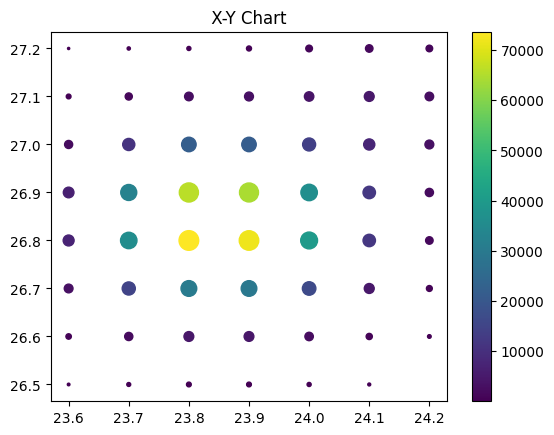

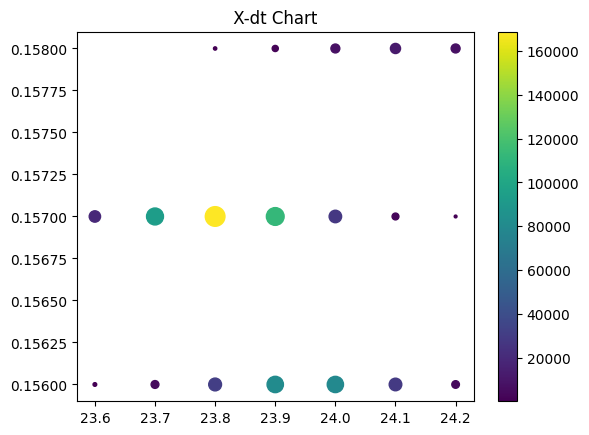

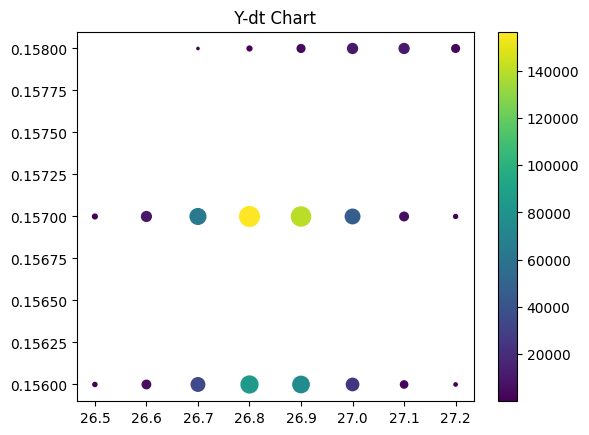

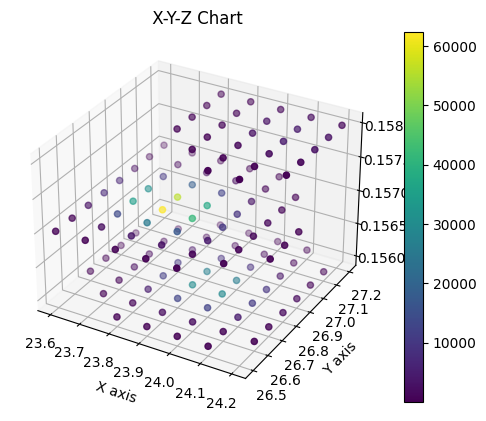

In [56]:
plotReadout(ReadoutEvt)